### imports and inits

In [1]:
import hydra
from  notebook_utils import run_inference, send_batch_to_device

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch


/dlabscratch1/amani/miniconda3/envs/sigmae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


___
### analysis of the model outputs

In [2]:
def show_image(image):
    image = image.cpu().detach().numpy()
    image_max = np.max(image)
    image_min = np.min(image)
    image = (image - image_min) / (image_max - image_min)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image.transpose(1, 2, 0))
    plt.imshow(image)   
    plt.show()



In [3]:
path = "/dlabscratch1/amani/sigmae/logs/train/runs/2024-09-13_20-51-11/"

batch_size = 32
model_path = path + "checkpoints/last.ckpt"
configs_path = path + ".hydra/"
config_name = "config.yaml"
with hydra.initialize_config_dir(config_dir=configs_path, version_base="1.2"):
    config = hydra.compose(config_name=config_name, 
                           overrides=[f"data.batch_size={batch_size}", 
                                    f"ckpt_path={model_path}"
                                    ])

model, datamodule = run_inference(config)
datamodule.processor_z = model.processor_z
datamodule.processor_x = None # for image text
datamodule.setup('test', processor_z=model.processor_z)

test_datamodule = datamodule.test_dataloader()
batch = next(iter(test_datamodule))
batch = send_batch_to_device(batch, model.device)
# output = model.forward(batch['x'], batch['z'], batch['data_type'])

Global seed set to 42


Current working directory: /mnt/dlabscratch1/amani/sigmae/notebooks
Instantiating data module <src.data.datamodule.image_lightning_datamodule.ImagePLDataModule>
Instantiating model <src.models.sigmae_lit_module_im_to_text.SigmaeLitModuleImageToText>


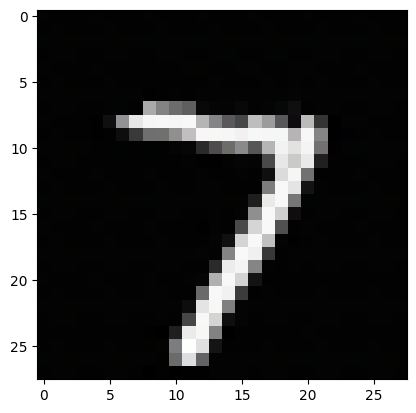

In [4]:
# teacherforced_outputs
# noise = torch.randn_like(batch['z'])
output_teacher_forced = model.forward(batch['x'], batch['z'], batch ['data_type'])
image_patches_teacher_forced = output_teacher_forced[0]['zxz']['id_z']

image_teacher_forced = model.fold(image_patches_teacher_forced[:,:-1,...].permute (0, 2, 1)) 
show_image(image_teacher_forced[0])

In [5]:
# autoreg_outputs

# output_autoreg = model.symbolic_autoencoder_wrapper_zxz(x_embeds_enc=, teacher_force_z=False)
output_teacher_forced = model.forward(batch['x'], batch['z'], batch ['data_type'], stage='val')
image_patches_autoreg = output_autoreg['id_z']
image_autoreg = model.fold(image_patches_autoreg.permute (0, 2, 1)) 
show_image(image_autoreg[0])

TypeError: 'NoneType' object is not subscriptable

In [44]:
i = 1
image_patches_autoreg[:, i, :] - image_patches_teacher_forced[:, i, :]

tensor([[0.9508, 0.9445, 0.9149,  ..., 0.5979, 0.9522, 0.9990],
        [0.9682, 0.9511, 0.9717,  ..., 0.8292, 0.8281, 0.8672],
        [0.9542, 0.9480, 0.9975,  ..., 1.0013, 1.0097, 0.9951],
        ...,
        [0.9214, 0.9577, 0.9953,  ..., 0.6729, 0.9145, 1.0043],
        [0.9539, 0.9479, 0.9968,  ..., 1.0015, 1.0096, 0.9960],
        [0.9544, 0.9478, 0.9967,  ..., 1.0016, 1.0095, 0.9957]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [21]:
image_patches_teacher_forced[:, 3, :]

tensor([[-8.6364e-04, -1.0076e-03, -1.3962e-04,  ..., -1.7921e-03,
         -1.3089e-03, -1.1953e-03],
        [ 5.1957e-03, -8.2200e-03, -3.2266e-03,  ...,  7.7242e-01,
          5.8483e-01,  4.2395e-01],
        [-8.6363e-04, -1.0076e-03, -1.3965e-04,  ..., -1.7921e-03,
         -1.3089e-03, -1.1953e-03],
        ...,
        [-8.6364e-04, -1.0076e-03, -1.3965e-04,  ..., -1.7921e-03,
         -1.3089e-03, -1.1953e-03],
        [-8.6365e-04, -1.0076e-03, -1.3962e-04,  ..., -1.7921e-03,
         -1.3089e-03, -1.1953e-03],
        [-8.6365e-04, -1.0076e-03, -1.3962e-04,  ..., -1.7921e-03,
         -1.3089e-03, -1.1953e-03]], device='cuda:0', grad_fn=<SliceBackward0>)

In [20]:
image_patches_autoreg[:, 3, :]

tensor([[0.1636, 0.7619, 0.9364,  ..., 0.9752, 1.0048, 0.9996],
        [0.1636, 0.7619, 0.9364,  ..., 0.9752, 1.0048, 0.9996],
        [0.1636, 0.7619, 0.9364,  ..., 0.9752, 1.0048, 0.9996],
        ...,
        [0.1636, 0.7619, 0.9364,  ..., 0.9752, 1.0048, 0.9996],
        [0.1636, 0.7619, 0.9364,  ..., 0.9752, 1.0048, 0.9996],
        [0.1636, 0.7619, 0.9364,  ..., 0.9752, 1.0048, 0.9996]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [22]:
image_teacher_forced[:, 0]

tensor([[[-7.1801e-04, -9.3409e-04,  5.9456e-06,  ..., -9.6493e-04,
          -1.0692e-04, -1.1823e-03],
         [-1.4181e-03, -5.3994e-04, -5.9152e-04,  ..., -6.0984e-04,
          -5.1760e-04, -9.3542e-04],
         [-1.2919e-03, -1.4565e-03, -2.9131e-04,  ..., -1.3669e-03,
          -2.5395e-04, -1.2880e-03],
         ...,
         [-1.5198e-03, -6.0817e-04, -4.9685e-04,  ..., -6.4965e-04,
          -4.4664e-04, -7.3398e-04],
         [-1.2684e-03, -1.4026e-03, -3.1656e-04,  ..., -1.3567e-03,
          -2.7505e-04, -1.0814e-03],
         [-1.1158e-03, -1.8900e-03, -5.7086e-04,  ..., -1.9360e-03,
          -6.0920e-04, -1.6013e-03]],

        [[-7.1799e-04, -9.3410e-04,  5.9605e-06,  ..., -1.0765e-03,
          -1.0438e-04, -1.0948e-03],
         [-1.4181e-03, -5.3994e-04, -5.9151e-04,  ..., -3.3652e-04,
          -5.0855e-04, -8.3730e-04],
         [-1.2919e-03, -1.4565e-03, -2.9130e-04,  ..., -1.4874e-03,
          -6.9041e-05, -1.0843e-03],
         ...,
         [-1.6353e-03, -6

In [26]:
output_autoreg['vector_decoder']

tensor([[[ 0.0112,  0.0343,  0.0105,  ..., -0.0282, -0.0285, -0.0084],
         [-0.0492, -0.0887, -0.0655,  ...,  0.0032, -0.1295, -0.0227],
         [-0.1376, -0.0494, -0.2219,  ...,  0.1565, -0.0369, -0.0224],
         ...,
         [-0.0080, -0.0239, -0.0461,  ...,  0.2163, -0.0770,  0.0238],
         [-0.0096, -0.0118, -0.0663,  ...,  0.2487, -0.0482,  0.0314],
         [-0.0173, -0.0283, -0.0710,  ...,  0.2300, -0.0687,  0.0221]],

        [[ 0.0112,  0.0343,  0.0105,  ..., -0.0282, -0.0285, -0.0084],
         [-0.0492, -0.0887, -0.0655,  ...,  0.0032, -0.1295, -0.0227],
         [-0.1376, -0.0494, -0.2219,  ...,  0.1565, -0.0369, -0.0224],
         ...,
         [-0.0080, -0.0239, -0.0461,  ...,  0.2163, -0.0770,  0.0238],
         [-0.0096, -0.0118, -0.0663,  ...,  0.2487, -0.0482,  0.0314],
         [-0.0173, -0.0283, -0.0710,  ...,  0.2300, -0.0687,  0.0221]],

        [[ 0.0112,  0.0343,  0.0105,  ..., -0.0282, -0.0285, -0.0084],
         [-0.0492, -0.0887, -0.0655,  ...,  0

In [46]:
output_teacher_forced[0]['zxz']['vector_decoder']

tensor([[[-0.0492, -0.0887, -0.0655,  ...,  0.0032, -0.1295, -0.0227],
         [-0.1464, -0.1128, -0.0843,  ...,  0.0240, -0.1442,  0.0131],
         [-0.0494, -0.0887, -0.0656,  ...,  0.0033, -0.1296, -0.0229],
         ...,
         [-0.0494, -0.0888, -0.0660,  ...,  0.0035, -0.1293, -0.0232],
         [-0.0493, -0.0888, -0.0657,  ...,  0.0033, -0.1295, -0.0229],
         [-0.1815, -0.0706, -0.1354,  ...,  0.0694, -0.1277,  0.0426]],

        [[-0.0492, -0.0887, -0.0655,  ...,  0.0032, -0.1295, -0.0227],
         [-0.0760, -0.1037, -0.0664,  ..., -0.0266, -0.1419, -0.0392],
         [-0.0882, -0.0762, -0.0999,  ...,  0.0243, -0.1264,  0.0083],
         ...,
         [-0.0492, -0.0887, -0.0655,  ...,  0.0034, -0.1296, -0.0228],
         [-0.0492, -0.0888, -0.0658,  ...,  0.0034, -0.1295, -0.0228],
         [-0.0470, -0.0870, -0.0684,  ...,  0.0274, -0.1314, -0.0276]],

        [[-0.0492, -0.0887, -0.0655,  ...,  0.0032, -0.1295, -0.0227],
         [-0.0493, -0.0887, -0.0656,  ...,  0

In [47]:
model.discretizer_z.linear_head

Linear(in_features=512, out_features=48, bias=True)

#### printing stuff 

In [ ]:
id = 42
dataset='val'

# print('supervised model 0.04:')
# forward(model_sup_004, datamodule_sup_004, id, dataset=dataset)
# print('curriculum model 0.04:')
# forward(model_cur_004, datamodule_cur_004, id, dataset=dataset)

################################################ single model ##########################################################
print('id:{} dataset:{}'.format(id, dataset))
forward(model, datamodule, id, dataset=dataset)

In [ ]:
print_neat_matrix(model.disc_x.dictionary.weight)
# torch.linalg.vector_norm(model.disc_x.dictionary.weight, dim=-1)

In [ ]:
for param in model.parameters():
    print(param.isnan().any())
    

In [ ]:
list(model.named_parameters())

In [ ]:
param = next(iter(model.parameters()))

In [ ]:
param.isnan().any()

In [ ]:
param

In [ ]:
id = 20
model = model
datamodule = datamodule
print(datamodule.data_train[id])
pred_from_sample(model, datamodule, 'turn left after walk opposite right', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right', print_x_or_z='z')
pred_from_sample(model, datamodule, 'turn left', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right after turn left', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right after turn left and walk opposite right after turn left', print_x_or_z='z')

In [ ]:
model = model
z_vocab = ['I_RUN', 'I_JUMP', 'I_WALK', 'I_LOOK', 'I_TURN_LEFT', 'I_TURN_RIGHT', ]
x_vocab = ['left', 'thrice', 'after','and', 'right', 'turn', 'run', 'walk', 'look', 'jump', 'opposite', 
        'around', 'twice']

pred_from_sample(model, 'I_JUMP', print_x_or_z='x')
pred_from_sample(model, 'I_JUMP I_JUMP', print_x_or_z='x')
pred_from_sample(model, 'I_JUMP I_JUMP I_JUMP', print_x_or_z='x')
pred_from_sample(model, 'I_JUMP I_JUMP I_JUMP I_JUMP', print_x_or_z='x')


pred_from_sample(model, 'jump and jump', print_x_or_z='z')
pred_from_sample(model, 'jump twice', print_x_or_z='z')
pred_from_sample(model, 'jump twice and jump', print_x_or_z='z')
pred_from_sample(model, 'jump and jump and jump', print_x_or_z='z')
pred_from_sample(model, 'jump and jump and jump and jump', print_x_or_z='z')
pred_from_sample(model, 'jump around left', print_x_or_z='z')


In [ ]:
model = model_sup_004
sentence = 'walk twice and turn left twice'
pred_from_sample(model, sentence, print_x_or_z='z')
model = model_cur_004
pred_from_sample(model, sentence, print_x_or_z='z')

#### ameliorated val datapoints from the dataset

In [ ]:
correct_z_ids_cur, correct_x_ids_cur = correct_val_predictions(model_cur_004, datamodule_cur_004)
correct_z_ids_sup, correct_x_ids_sup = correct_val_predictions(model_sup_004, datamodule_sup_004)
intersection = list(set(correct_z_ids_cur).intersection(set(correct_x_ids_cur)))
lost_z_ids_by_cur = list(set(correct_z_ids_sup).difference(set(correct_z_ids_cur)))
found_z_ids_by_cur = list(set(correct_z_ids_cur).difference(set(correct_z_ids_sup)))

In [ ]:
print('curriculum accuracy: ', len(correct_z_ids_cur)/len(datamodule_cur_004.data_val))
print('supervised accuracy: ', len(correct_z_ids_sup)/len(datamodule_sup_004.data_val))

In [ ]:
print('size of lost z ids by curr: ',len(lost_z_ids_by_cur))
print('size of found z ids by curr: ',len(found_z_ids_by_cur))

i = 20
print('supervised model 0.04:')
forward(model_sup_004, datamodule_sup_004, lost_z_ids_by_cur[i])
print('curriculum model 0.04:')
forward(model_cur_004, datamodule_cur_004, lost_z_ids_by_cur[i])


In [ ]:
i = 50
print('supervised model 0.04:')
forward(model_sup_004, datamodule_sup_004, found_z_ids_by_cur[i])
print('curriculum model 0.04:')
forward(model_cur_004, datamodule_cur_004, found_z_ids_by_cur[i])


In [ ]:
len(correct_z_ids_sup)

In [ ]:
len(correct_z_ids_cur)

### why is the fully supervised model with perfect loss not working well on zxz and xzx?

In [ ]:
batch_size = 128
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/suponly-[0.99, 0.9]-gpt2_gpt2-vqvae/2023-11-15_13-48-10/checkpoints/last.ckpt'"

with hydra.initialize(config_path=configs_path, version_base="1.2"):
    config_sup = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.99,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])

model_sup , datamodule_sup = run_inference(config_sup)

In [ ]:
id = 20
model = model_sup
datamodule = datamodule_sup
print(datamodule_sup.data_train[id])
forward(model_sup, datamodule_sup, id, dataset='train')
pred_from_sample(model, datamodule, 'turn left after walk opposite right', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right', print_x_or_z='z')
pred_from_sample(model, datamodule, 'turn left', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right after turn left', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right after turn left and walk opposite right after turn left', print_x_or_z='z')

In [ ]:
print(model.disc_x.dictionary.weight)
dictionary_cosine_sim(model, alphabet='x', bins=100)
dictionary_inner_prod_sim(model, alphabet='x', bins=100)

In [ ]:
correct_z_ids, correct_x_ids = correct_val_predictions(model_sup, datamodule_sup)

---
## model weights analysis

In [ ]:
# set of functions
def dictionary_cosine_sim(model, alphabet='x', bins=100):
    if alphabet == 'x':
        kernel = model.disc_x.state_dict()['dictionary.weight'].cpu().numpy()
    elif alphabet == 'z':
        kernel = model.disc_z.state_dict()['dictionary.weight'].cpu().numpy()
    # cosine similarity
    inner_prods = kernel.dot(kernel.T)
    lengths = np.linalg.norm(kernel, axis=1)
    length_matrix = np.outer(lengths, lengths)
    kernel = np.round(inner_prods / length_matrix, decimals=2)
    u = plt.hist(kernel.flatten(), bins=bins)
    plt.show()
    return kernel, u


def dictionary_inner_prod_sim(model, alphabet='x', bins=100):
    if alphabet == 'x':
        kernel = model.disc_x.state_dict()['dictionary.weight'].cpu().numpy()
    elif alphabet == 'z':
        kernel = model.disc_z.state_dict()['dictionary.weight'].cpu().numpy()
    inner_prods = kernel.dot(kernel.T)
    kernel = np.round(inner_prods, decimals=2)
    u = plt.hist(kernel.flatten(), bins=bins)
    plt.show()
    return kernel, u



In [ ]:
kernel, u = dictionary_inner_prod_sim(model, alphabet='z', bins=100)
print_neat_matrix(kernel)

In [ ]:
batch_size = 10
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/suponly-[0.04, 0.9]-gpt2_gpt2-vqvae/2023-10-15_14-51-47/checkpoints/last.ckpt'"
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    config_sup_004 = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])

model_sup_004 , datamodule_sup_004 = run_inference(config_sup_004)

batch_size = 10
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/curriculum-[0.04, 0.9]-gpt2_gpt2-vqvae/2023-10-17_14-13-22/checkpoints/last.ckpt'"
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    config_cur_004 = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])

model_cur_004, datamodule_cur_004 = run_inference(config_cur_004)
    

In [ ]:

annot = False
for alph in ['x', 'z']:
    if alph == 'x':
        bin = 100
        tokenizer=model.collator.tokenizer_x
    elif alph == 'z':
        bin = 20
        tokenizer=model.collator.tokenizer_z
    print(alph)
    for type in ['sup', 'cur']:
        print(type)
        if type == 'sup':
            model = model_sup_004
        elif type == 'cur':
            model = model_cur_004
        cosine_kernel, cosine_u = dictionary_cosine_sim(model, alphabet=alph, bins=bin)

        sorted_vocab = sorted(tokenizer.get_vocab().items(), key=lambda x: x[1])
        sorted_vocab = [x[0] for x in sorted_vocab]

        plt.figure()
        plt.title(alph+' '+type+' cosine similarity')
        sns.heatmap(cosine_kernel, cmap="coolwarm", annot=annot, xticklabels=sorted_vocab, yticklabels=sorted_vocab)
        plt.show()

        inner_prod_kernel, inner_prod_u = dictionary_inner_prod_sim(model, alphabet=alph, bins=bin)
        plt.figure()
        plt.title(alph+' '+type+' inner product similarity')
        sns.heatmap(inner_prod_kernel, cmap="coolwarm", annot=annot, xticklabels=sorted_vocab, yticklabels=sorted_vocab)
        plt.show()


# cos_sup_004, u_sup_004 = dictionary_cosine_sim(model_sup_004, bins=bin)
# cos_cur_004, u_cur_004 = dictionary_cosine_sim(model_cur_004, bins=bin)
# sns.heatmap(cos_sup_004, cmap="coolwarm", annot=True)
# plt.show()
# sns.heatmap(cos_cur_004, cmap="coolwarm", annot=True)
# plt.show()

### loading other datamodules and sampling outputs for the paper

In [ ]:
%cd ..
from src import utils
import hydra
from omegaconf import DictConfig
import numpy as np
import os
import torch
from src.utils.metrics import pad_label_label
# from src.utils import general_helpers
from typing import List
import seaborn as sns

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.loggers.logger import Logger

import src.utils.general as utils
# Load config
import hydra
import matplotlib.pyplot as plt

log = utils.get_pylogger(__name__)

configs_path = "../configs"
config_name = "inference_root.yaml"
work_dir='/dlabdata1/masani/blocks/'
batch_size = 32
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/suponly-[0.99, 0.9]-gpt2_gpt2-vqvae/2023-11-17_15-54-41/checkpoints/last.ckpt'"

def load_datamodule(config: DictConfig):
    # assert config.output_dir is not None, "Path to the directory in which the predictions will be written must be given"
    # config.output_dir = general_helpers.get_absolute_path(config.output_dir)
    # log.info(f"Output directory: {config.output_dir}")

    # Set seed for random number generators in PyTorch, Numpy and Python (random)
    if config.get("seed"):
        pl.seed_everything(config.seed, workers=True)
    
    # print current working directory
    print(f"Current working directory: {os.getcwd()}")

    print(f"Instantiating data module <{config.datamodule._target_}>")
    datamodule: LightningDataModule = hydra.utils.instantiate(config.datamodule, _recursive_=False)

    return datamodule

def print_sample(datamodule, num_sample):
    ids = np.random.randint(0, len(datamodule.data_val), num_sample)
    for id in ids:
        print('id: ', id)
        print('x: ', datamodule.data_val[int(id)]['x'])
        print('z: ', datamodule.data_val[int(id)]['z'])
        print('_____________________________________________________________________________________')


In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=cfq", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}",
                                      "work_dir='/dlabdata1/masani/blocks/'"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)

In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=cogs", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}",
                                      "work_dir='/dlabdata1/masani/blocks/'"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)

In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=pcfg_set", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}",
                                      "work_dir='/dlabdata1/masani/blocks/'"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)

In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=sfst", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)

In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)